<a href="https://colab.research.google.com/github/murnanedaniel/GNN-Sandbox/blob/master/notebooks/GNN_Tutorial_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

In [0]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from toy_utils import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

It's boring, but need to ensure all the versions match up....

In [0]:
import torch; print("Torch version:", torch.__version__, ", CUDA version:", torch.version.cuda)

Torch version: 1.4.0 , CUDA version: 10.1


Provided the CUDA version is 10.1, we pip install libraries with "latest+cu101". If CUDA is 10.0, for example, then we install with "latest+cu100".

In [0]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 353kB/s 
     |████████████████████████████████| 9.6MB 49.9MB/s 
  Found existing installation: torch-scatter 2.0.3
    Uninstalling torch-scatter-2.0.3:
      Successfully uninstalled torch-scatter-2.0.3
  Found existing installation: torch-sparse 0.5.1
    Uninstalling torch-sparse-0.5.1:
      Successfully uninstalled torch-sparse-0.5.1


In [0]:
!pip install torch-geometric

## The Problem

### Toy Data

In [0]:
# Circle parameters
num_layers = 10
height, width = 10, 10
min_curve, max_curve = 15, 50
noise = False
event_size_min, event_size_max = 4, 12 #I.E. The number of true particle tracks
max_angle=(4/6)*np.pi

**Include feature scale as normalisation** !

In [0]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [0]:
def plot_toy_graph(event):
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
#     for i, j in zip(X[e[0]], X[e[1]]):
#         plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    plt.ylim(-1,1)

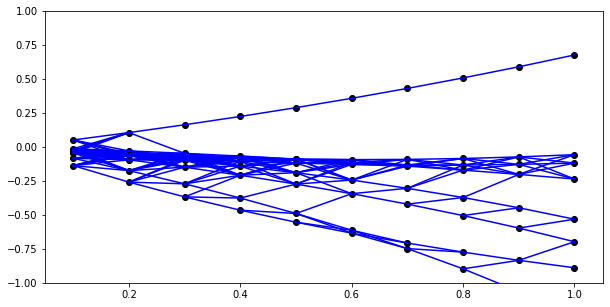

In [0]:
plot_toy_graph(test_dataset[0])

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

In [0]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  2.6666666666666665


### Real Data

The data from a (good) simulation is much more busy. Let's load a TrackML event and visualise it

In [0]:
import trackml.dataset
from prepare import select_segments, select_hits, calc_dphi

In [0]:
# Geometric and physics cuts
pt_min = 1
phi_slope_max = .001
z0_max = 200

# Graph features and scale
feature_names = ['r', 'phi', 'z']
feature_scale = np.array([1000., np.pi, 1000.])

In [0]:
def build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale):
    hits, particles, truth = trackml.dataset.load_event(
        event_file, parts=['hits', 'particles', 'truth'])
    hits = select_hits(hits, truth, particles, pt_min=pt_min).assign(evtid=int(event_file[-9:]))
    
    # Define adjacent layers
    n_det_layers = 10
    l = np.arange(n_det_layers)
    layer_pairs = np.stack([l[:-1], l[1:]], axis=1)
    
    layer_groups = hits.groupby('layer')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            logging.info('skipping empty layer: %s' % e)
            continue
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max, z0_max))
        # Combine segments from all layer pairs
    segments = pd.concat(segments)
    
    X = (hits[feature_names].values / feature_scale).astype(np.float32)
    n_edges = len(segments)
    n_hits = len(hits)
    
    pid1 = hits.particle_id.loc[segments.index_1].values
    pid2 = hits.particle_id.loc[segments.index_2].values
    y = np.zeros(n_edges, dtype=np.float32)
    y[:] = (pid1 == pid2)
    
    hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
    seg_start = hit_idx.loc[segments.index_1].values
    seg_end = hit_idx.loc[segments.index_2].values
    
    e = np.vstack([seg_start, seg_end])
    
    return X, e, y

In [0]:
event_file = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009995"

In [0]:
X, e, y = build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale)

In [0]:
def plot_trackml_graph(X, e, feature_scale):
    X = X * feature_scale
    x = X[:,0] * np.cos(X[:,1])
    y = X[:,0] * np.sin(X[:,1])
    plt.figure(figsize=(15,15))
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
#     plt.ylim(-10,10)

CPU times: user 3.18 s, sys: 51.7 ms, total: 3.23 s
Wall time: 3.23 s


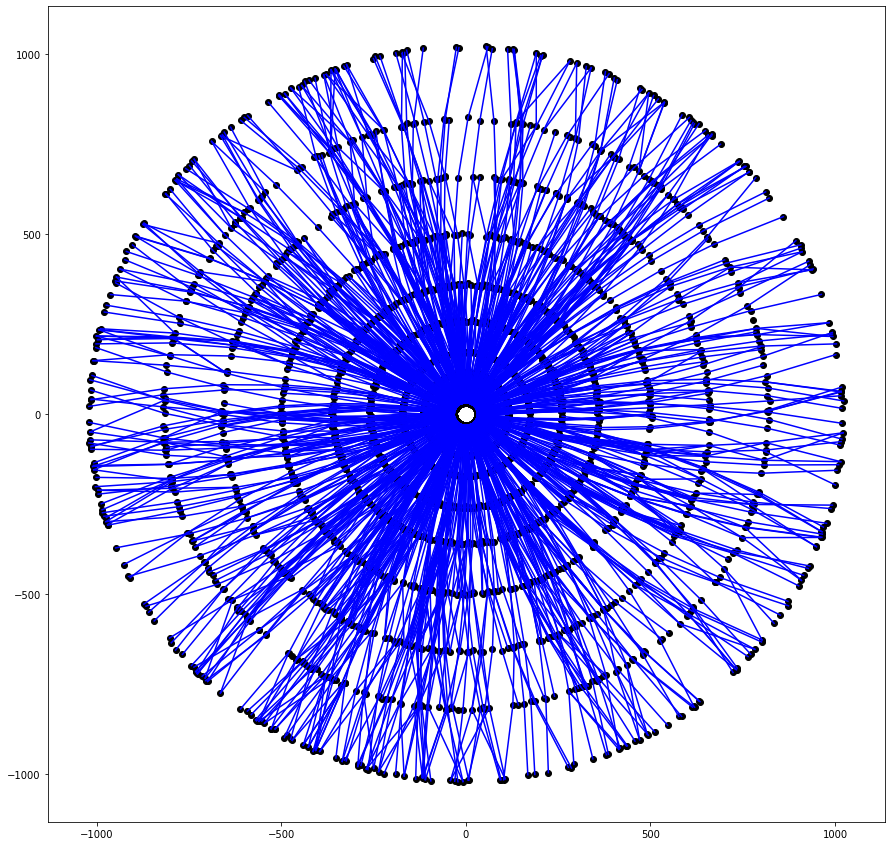

In [0]:
%%time
plot_trackml_graph(X, e, feature_scale)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Repeat (2) and (3) n_graph_iters times
5. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [0]:
# Externals
import torch
import torch.nn as nn
from torch_scatter import scatter_add

# Locals
from model_utils import make_mlp


class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
#         edges = data.edge_index
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
#             x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
#             edge_inputs = torch.cat([x[edges[0]], x[edges[1]]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
#             aggr_messages = scatter_add(e, edges[1], dim=0, dim_size=x.shape[0])
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
#             x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build the model...

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

### Training on Toy Data

Choose an optimiser (of course Adam)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [0]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

weight = 3
m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.7278
Epoch: 2, Accuracy: 0.7361
Epoch: 3, Accuracy: 0.7115
Epoch: 4, Accuracy: 0.6974
Epoch: 5, Accuracy: 0.7164
Epoch: 6, Accuracy: 0.7157
Epoch: 7, Accuracy: 0.7158
Epoch: 8, Accuracy: 0.7142
Epoch: 9, Accuracy: 0.7145
Epoch: 10, Accuracy: 0.7180
Epoch: 11, Accuracy: 0.7181
Epoch: 12, Accuracy: 0.7271
Epoch: 13, Accuracy: 0.7218
Epoch: 14, Accuracy: 0.7279
Epoch: 15, Accuracy: 0.7212
Epoch: 16, Accuracy: 0.7317
Epoch: 17, Accuracy: 0.7285
Epoch: 18, Accuracy: 0.7284
Epoch: 19, Accuracy: 0.7413
Epoch: 20, Accuracy: 0.7307
Epoch: 21, Accuracy: 0.7271
Epoch: 22, Accuracy: 0.7329
Epoch: 23, Accuracy: 0.7211
Epoch: 24, Accuracy: 0.7343
Epoch: 25, Accuracy: 0.7527
Epoch: 26, Accuracy: 0.7697
Epoch: 27, Accuracy: 0.7813
Epoch: 28, Accuracy: 0.7795
Epoch: 29, Accuracy: 0.7908
Epoch: 30, Accuracy: 0.8025
Epoch: 31, Accuracy: 0.8113
Epoch: 32, Accuracy: 0.8173
Epoch: 33, Accuracy: 0.8230
Epoch: 34, Accuracy: 0.8250
Epoch: 35, Accuracy: 0.8318
Epoch: 36, Accuracy: 0.8296
E

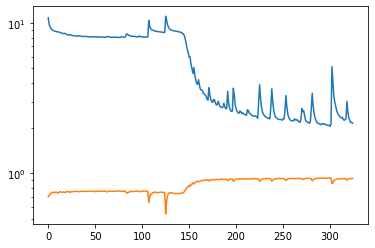

In [0]:
plt.plot(np.arange(len(t_loss_v)), t_loss_v)
plt.plot(np.arange(len(t_acc_v)), t_acc_v)
plt.yscale("log")

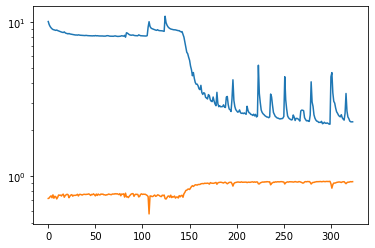

In [0]:
plt.plot(np.arange(len(v_loss_v)), v_loss_v)
plt.plot(np.arange(len(v_acc_v)), v_acc_v)
plt.yscale("log")

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [0]:
def plot_toy_classified(event, preds, cut=0.5):
    
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    
    for j in range(len(labels)):
        
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

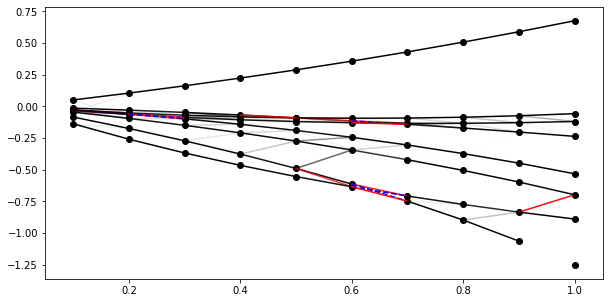

In [0]:
data = test_loader.dataset[0].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
plot_toy_classified(data.to('cpu'), preds, cut = 0.6)

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests

In [0]:
best_acc = np.zeros(10)
for i in range(1,11):
    m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": i, "layer_norm": True}
    model = MPNN_Network(**m_configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
    for epoch in range(200):
        ep += 1  
        model.train()
        acc, total_loss = train(model, train_loader, optimizer)
        t_loss_v.append(total_loss)
        t_acc_v.append(acc)

        model.eval()
        acc, total_loss = evaluate(model, test_loader)
        if acc > best_acc[i-1]: best_acc[i-1] = acc
        v_loss_v.append(total_loss)
        v_acc_v.append(acc)

        print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))
plt.plot(np.arange(len(best_acc)), best_acc)

## Moving to "Real" Data

We need to create a dataset from the TrackML data, which may take a little while...

In [0]:
def prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale):
    print("Preparing",event_file)
    X, e, y = build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale)
    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y))
    return data

In [0]:
one_event = prepare_event(event_file = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009995")

In [0]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/"
all_events = os.listdir(input_dir)
all_events = [input_dir + event[:14] for event in all_events]

Build the graphs. This will take less than 5 minutes. I hope.

In [0]:
train_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale) for event_file in all_events[:100]]
test_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale) for event_file in all_events[-10:]]
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003444
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002090
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004632
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006798
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009422
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005182
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007411
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009981
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008434
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008265
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003099
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003376
Preparing /global/cscratch1/

### MPGNN on TrackML Data

To get the weight, we should again look at the fake:true ratio:

In [0]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  1.3395895895895895


It's actually pretty close! This is because we put a momentum cut that removed many edges that may have involved high curvature. Thus we have few fake edges. Try making the graphs with a lower pT cut and we will return many fake edges. We can now train the MPNN on the high-pT events.

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [0]:
weight = 2
m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 8, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.7394
Epoch: 2, Accuracy: 0.7606
Epoch: 3, Accuracy: 0.7672
Epoch: 4, Accuracy: 0.7735
Epoch: 5, Accuracy: 0.7735
Epoch: 6, Accuracy: 0.7796
Epoch: 7, Accuracy: 0.7864
Epoch: 8, Accuracy: 0.7873
Epoch: 9, Accuracy: 0.7878
Epoch: 10, Accuracy: 0.7899
Epoch: 11, Accuracy: 0.7920
Epoch: 12, Accuracy: 0.7932
Epoch: 13, Accuracy: 0.7938
Epoch: 14, Accuracy: 0.7942
Epoch: 15, Accuracy: 0.7875
Epoch: 16, Accuracy: 0.7942
Epoch: 17, Accuracy: 0.7940
Epoch: 18, Accuracy: 0.7926
Epoch: 19, Accuracy: 0.7930
Epoch: 20, Accuracy: 0.7959
Epoch: 21, Accuracy: 0.7965
Epoch: 22, Accuracy: 0.7936
Epoch: 23, Accuracy: 0.7967
Epoch: 24, Accuracy: 0.7971
Epoch: 25, Accuracy: 0.7993
Epoch: 26, Accuracy: 0.7972
Epoch: 27, Accuracy: 0.7988
Epoch: 28, Accuracy: 0.7852
Epoch: 29, Accuracy: 0.8014
Epoch: 30, Accuracy: 0.8122
Epoch: 31, Accuracy: 0.8178
Epoch: 32, Accuracy: 0.8517
Epoch: 33, Accuracy: 0.8695
Epoch: 34, Accuracy: 0.8662
Epoch: 35, Accuracy: 0.8829
Epoch: 36, Accuracy: 0.8878
E

KeyboardInterrupt: 

The same configuration (16 dims, 1 iteration, 2 hidden layers in each network) that gave us 90% on toy data actually works pretty well still (after many epochs). That's because the pT cut gives us quite clean graphs. However, putting up the graph iterations doesn't help with a small number of hidden dimensions. Essentially, the message passing is washing out the information contained in only 16 dimensions. We should increase them to harness the power of the message passing. With 64 dimensions, and 8 iterations, I get around 96% accuracy after 200 epochs. For real tracking data, this should be quite impressive. And remember we can tweak the efficiency and purity by altering the weight.

Visualising the model...

In [0]:
from IPython.display import clear_output

def plot_trackml_classified(event, preds, feature_scale, cut=0.5):
    X = event.x.numpy() * feature_scale
    x = X[:,0] * np.cos(X[:,1])
    y = X[:,0] * np.sin(X[:,1])
    
    plt.figure(figsize=(20,20))
#     x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    
    for j in range(len(labels)):
        if j%1000 == 0: 
            clear_output(wait=True)
            print("Plotting edge", j, "of", len(labels))
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

Plotting edge 12000 of 12181


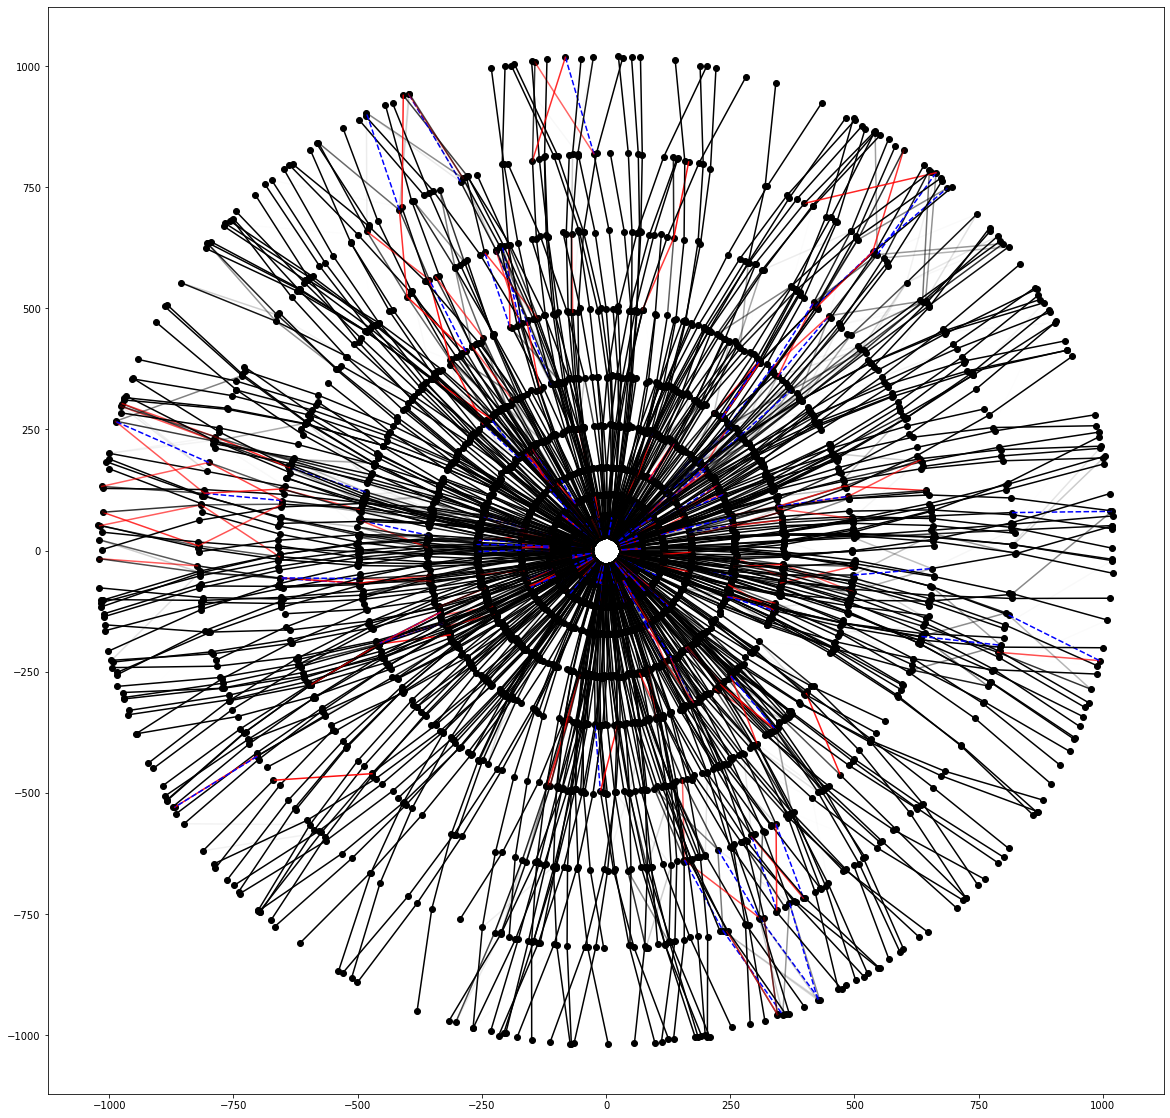

In [0]:
data = test_loader.dataset[0].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
plot_trackml_classified(data.to('cpu'), preds, feature_scale, cut = 0.6)

### The Attention mechanism in a GNN

The MPNN is working pretty well. Let's try and do better with a more sophisticated convolution function. Essentially, we run the classification network in every iteration, and use the score to weight how the node features are aggregated. In this way, the graph should learn what "attention" it gives to each edge connected to each node. We thus call it an Attention GNN (AGNN). Its model is given by

In [0]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class AGNN_Network(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation='Tanh', layer_norm=True):
        super(AGNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.edge_network(x, inputs.edge_index)

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [0]:
weight = 2
m_configs = {"input_dim": 3, "hidden_dim": 64, "n_graph_iters": 1, "layer_norm": True}
model = AGNN_Network(**m_configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

### Did the AGNN help?

## Optimising the GNN

### Simple HPO

### Sweep HPO

### Generalising Message Passing mechanism